# Coding Assignment 2

#### by Arnav Das (arnavmd2@uw.edu)

# Introduction to the Assignment  

In this assignment, you will build a model to **classify the sentiment of Yelp reviews**.

The **Yelp Reviews** dataset is a large collection of restaurant and business reviews written by users and annotated with **sentiment labels**.  
Each example contains a piece of review text along with a label indicating how positive or negative the reviewer’s experience was.

The goal is to **understand and categorize the sentiment expressed in each review** based solely on its text.

The labels correspond to different levels of sentiment:

#### 1-star — Strongly negative  
#### 2-star — Negative  
#### 3-star — Neutral  
#### 4-star — Positive  
#### 5-star — Strongly positive  

This dataset is widely used in **text classification and sentiment analysis**, making it a strong benchmark for evaluating how well models can interpret opinions, tone, and emotional content in written language.

# Part 1: Dataset Exploration (10 points)

Here we will do some quick sanity checks on the dataset, before we do any sort of training.

In [9]:
from datasets import load_dataset

SEED = 42
N_TRAIN = 50_000
N_VAL   = 5_000
N_EVAL  = 500

ds = load_dataset("yelp_review_full")
train_full = ds["train"].shuffle(seed=SEED)
train = train_full.select(range(N_TRAIN))
val   = train_full.select(range(N_TRAIN, N_TRAIN + N_VAL))

test = ds["test"].shuffle(seed=SEED).select(range(N_EVAL))

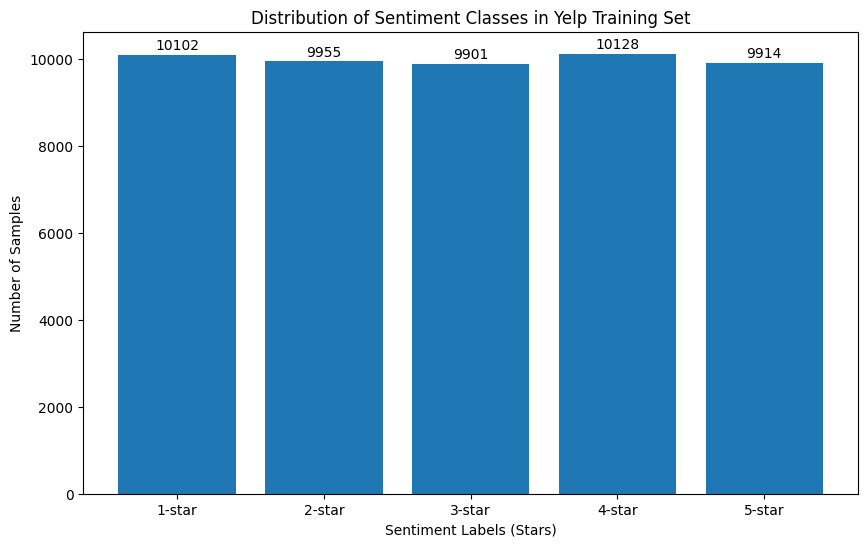

In [10]:
#TODO Put your code here (2.5 pts).
###########################################################################
# Plot a bar graph, that shows how many samples there are each class
import matplotlib.pyplot as plt
import pandas as pd


train_labels = train['label']
label_series = pd.Series(train_labels)
counts = label_series.value_counts().sort_index()
class_names = ['1-star', '2-star', '3-star', '4-star', '5-star']
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, counts)

plt.title('Distribution of Sentiment Classes in Yelp Training Set')
plt.xlabel('Sentiment Labels (Stars)')
plt.ylabel('Number of Samples')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, yval, ha='center', va='bottom')

plt.show()


###########################################################################

In [11]:
import re
from collections import Counter
from tqdm import tqdm

NUM_CLASSES = 5
N = 5  # Try a few different values for this
MAX_SAMPLES = 10_000 # We only look at 10_000 samples for speed

# Each class label (0–4) gets its own Counter
ngram_counts = {i: Counter() for i in range(NUM_CLASSES)}


# Low level tokens like the ones BERT uses are not that useful, so we will construct coarser tokens for analysis
def simple_tokenize(text):
    text = text.lower()
    text = text.replace("\n", " ")
    text = re.sub(r"[^a-z0-9' ]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.split(" ")


for i, example in tqdm(enumerate(train)):
    if MAX_SAMPLES and i >= MAX_SAMPLES:
        break

    text = example["text"]
    label = example["label"]

    tokens = simple_tokenize(text)
    pass
    #TODO: Put your code here (2.5 pts).
    for i in range(len(tokens) - N + 1):
        ngram = tuple(tokens[i : i + N])
        ngram_counts[label][ngram] += 1

    ###########################################################################
    #   Build all N-grams from `tokens` and count them
    #   in `ngram_counts[label]`
    #
    #   An N-gram is a tuple of N consecutive tokens.
    #
    #   Example (N=3):
    #     tokens = ["this","place","is","really","good"]
    #     trigrams = [
    #        ("this","place","is"),
    #        ("place","is","really"),
    #        ("is","really","good")
    #     ]
    # --------------------------------------------------
    ###########################################################################



# Extract top 5 n-grams per class
top_ngrams = {i: ngram_counts[i].most_common(5) for i in range(NUM_CLASSES)}

star_names = {
    0: "1-star",
    1: "2-star",
    2: "3-star",
    3: "4-star",
    4: "5-star",
}

for label in range(NUM_CLASSES):
    print("\n", star_names[label])
    for (ngram, count) in top_ngrams[label]:
        print(f"{' '.join(ngram):30s}  {count}")


10000it [00:04, 2249.30it/s]



 1-star
i will never go back            16
at the end of the               15
recommend this place to anyone  14
in the middle of the            12
i will not be returning         11

 2-star
do do do do do                  32
in the middle of the            19
wanted to like this place       13
get what you pay for            13
the best part of the            12

 3-star
in the middle of the            18
go out of my way                13
www yelp com biz photos         13
nothing to write home about     12
out of my way to                11

 4-star
is a great place to             17
just the right amount of        13
www yelp com biz photos         13
i will definitely be back       12
if you are looking for          12

 5-star
can't wait to go back           19
if you are looking for          14
is a great place to             14
is one of the best              13
you are looking for a           10


# Part 3: BERT-Based Classification (50 points)

Now we use BERT as a feature extractor for classification.
We keep BERT frozen and train a small neural network on top of it to predict the labels.

In [12]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [14]:
# Function for tokenizing text
def manual_encode(text, max_length=512):
    """
    Encode a single Yelp review for BERT.
    Format: [CLS] text [SEP]
    """

    # Tokenize the text, and pad to max_length for collation
    tokens = tokenizer.tokenize(text)
    max_text_len = max_length - 2
    tokens = tokens[:max_text_len]
    tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    attention_mask = [1] * len(input_ids)

    # Pad to max_length
    padding_length = max_length - len(input_ids)
    input_ids += [tokenizer.pad_token_id] * padding_length
    attention_mask += [0] * padding_length

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask
    }


In [15]:
def update_dataset(example):
    return manual_encode(example["text"])

train = train.map(update_dataset)
val  = val.map(update_dataset)
test  = test.map(update_dataset)


train = train.remove_columns(["text"])
val = val.remove_columns(["text"])
test  = test.remove_columns(["text"])

train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader   = DataLoader(val, batch_size=32)
test_loader  = DataLoader(test, batch_size=32)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [16]:
import copy
import torch

@torch.no_grad()
def compute_embeddings(bert_model, loader, device, context_rep="cls"):
    bert_model.eval()
    all_embs = []
    all_labels = []

    for batch in tqdm(loader, desc=f"Embedding ({context_rep})"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state  # (B, T, H)

        if context_rep == "cls":
            #TODO Put your code here (5 points).
            ###########################################################################
            # last_hidden_state: (B, T, H); take [CLS] token at position 0
            emb = last_hidden[:, 0, :]
            ###########################################################################
            pass
        elif context_rep == "mean_pool":
            #TODO Put your code here (5 points).
            ###########################################################################
            # Mean pooling over tokens, ignoring padding via attention_mask
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
            sum_embeddings = torch.sum(last_hidden * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            emb = sum_embeddings / sum_mask
            ###########################################################################
            pass
        else:
            raise ValueError(f"Unknown context_rep: {context_rep}")

        all_embs.append(emb.cpu())
        all_labels.append(labels.cpu())

    X = torch.cat(all_embs, dim=0)      # (N, H)
    y = torch.cat(all_labels, dim=0)    # (N,)
    return X, y


class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def make_head(hidden_size, num_labels=5, classifier_type="linear"):
    if classifier_type == "linear":
        #TODO: Put your code here (5 points).
        # Add a linear layer which maps the pooled output of BERT to the number of desired classes (num_labels).
        # The linear layer essentially acts as a classifier on top of the BERT model, using the pooled representation of the input sequence to make class predictions.
        ###########################################################################
        clf = None
        clf = nn.Linear(hidden_size, num_labels)
        ###########################################################################
    elif classifier_type == "non-linear":
        #TODO: Put your code here (5 points).
        # Add two linear layers which map the pooled output of BERT to the number of desired classes (num_labels).
        # The first linear layer should be of size [hidden_size, 0.5*hidden_size]
        # The second linear layer should be of size [0.5*hidden_size, num_labels]
        # Add a RELU function between these two layers
        ###########################################################################
        clf = None
        mid_size = int(0.5 * hidden_size)
        clf = nn.Sequential(
            nn.Linear(hidden_size, mid_size),
            nn.ReLU(),
            nn.Linear(mid_size, num_labels)
        )
        ###########################################################################
    else:
        raise ValueError(f"Unknown classifier_type: {classifier_type}")


    return clf

def train_head(
    head,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=10,
    eval_every_epochs=1,
    eval_on_last_epoch=True,
):
    """
    Trains `head` and keeps the best-performing weights (by val_loss) in memory.
    Returns the head loaded with the best weights.

    Evaluation happens every `eval_every_epochs` epochs (at the end of the epoch),
    and optionally on the final epoch as well.
    """
    loss_fn = nn.CrossEntropyLoss()
    best_val_loss = float("inf")
    best_state = None  # in-memory copy of best weights

    def run_validation():
        head.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for Xv, yv in val_loader:
                #TODO: Put your code here (5 points).
                # This code is to loop over all validation set embeddings and compute the loss and accuracy
                ###########################################################################
                Xv, yv = Xv.to(device), yv.to(device)

                outputs = head(Xv)

                batch_loss = loss_fn(outputs, yv)
                val_loss += batch_loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == yv).sum().item()
                total += yv.size(0)
                ###########################################################################
                pass
        val_acc = correct/total

        return val_loss, val_acc


    for epoch in range(num_epochs):
        head.train()
        for X, y in tqdm(train_loader, desc=f"Head epoch {epoch+1}/{num_epochs}"):
            #TODO: Put your code here (10 points)
            # Add training logic here
            ###########################################################################
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            outputs = head(X)
            loss = loss_fn(outputs, y)

            loss.backward()

            optimizer.step()
            ###########################################################################
            pass

        should_eval = ((epoch + 1) % eval_every_epochs == 0) or (
            eval_on_last_epoch and (epoch + 1 == num_epochs)
        )
        if should_eval:
            val_loss, val_acc = run_validation()
            print(f"[epoch {epoch+1}] val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = copy.deepcopy(head.state_dict())
                print("  -> new best head kept in memory")

    # Load best weights back into `head` before returning
    if best_state is not None:
        head.load_state_dict(best_state)

    return head

In [17]:
# Function for evaluation and plotting confusion matrix (HEAD ONLY, EMBEDDING BATCHES ONLY)
def evaluate_and_plot(head, test_loader, device, classifier_type, context_rep):
    """
    Assumes:
      - test_loader yields batches of (X, y) from EmbeddingDataset
      - head(X) returns logits of shape (B, num_classes)
    """
    head.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)

            logits = head(X)
            preds = logits.argmax(dim=1)

            y_true.append(y.detach().cpu().numpy())
            y_pred.append(preds.detach().cpu().numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=["1★","2★","3★","4★","5★"],
        yticklabels=["1★","2★","3★","4★","5★"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix — {classifier_type} ({context_rep})")
    plt.show()

    accuracy = float((y_true == y_pred).mean()) if len(y_true) > 0 else 0.0
    print(f"classifier_type-{classifier_type} context_rep-{context_rep}")
    print(f"Accuracy: {accuracy:.4f}")

    return accuracy, cm

In [18]:
import numpy as np
# 1) Load BERT once and freeze it
device = 'cuda:0'
bert = BertModel.from_pretrained("bert-base-uncased").to(device)
for p in bert.parameters():
    p.requires_grad_(False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [19]:
# 2) Precompute embeddings ONCE
CONTEXT_REP = 'mean_pool' # 'cls, mean_pool'
X_train, y_train = compute_embeddings(bert, train_loader, device, context_rep=CONTEXT_REP)
X_val, y_val     = compute_embeddings(bert, val_loader, device, context_rep=CONTEXT_REP)
X_test, y_test   = compute_embeddings(bert, test_loader, device, context_rep=CONTEXT_REP)

Embedding (mean_pool):   0%|          | 0/1563 [00:00<?, ?it/s]

Embedding (mean_pool):   0%|          | 0/157 [00:00<?, ?it/s]

Embedding (mean_pool):   0%|          | 0/16 [00:00<?, ?it/s]

Head epoch 1/10:   0%|          | 0/1563 [00:00<?, ?it/s]

[epoch 1] val_loss=151.8163 val_acc=0.5678
  -> new best head kept in memory


Head epoch 2/10:   0%|          | 0/1563 [00:00<?, ?it/s]

[epoch 2] val_loss=152.9275 val_acc=0.5616


Head epoch 3/10:   0%|          | 0/1563 [00:00<?, ?it/s]

[epoch 3] val_loss=149.9525 val_acc=0.5732
  -> new best head kept in memory


Head epoch 4/10:   0%|          | 0/1563 [00:00<?, ?it/s]

[epoch 4] val_loss=149.3803 val_acc=0.5772
  -> new best head kept in memory


Head epoch 5/10:   0%|          | 0/1563 [00:00<?, ?it/s]

[epoch 5] val_loss=152.8657 val_acc=0.5642


Head epoch 6/10:   0%|          | 0/1563 [00:00<?, ?it/s]

[epoch 6] val_loss=149.7684 val_acc=0.5682


Head epoch 7/10:   0%|          | 0/1563 [00:00<?, ?it/s]

[epoch 7] val_loss=147.6319 val_acc=0.5808
  -> new best head kept in memory


Head epoch 8/10:   0%|          | 0/1563 [00:00<?, ?it/s]

[epoch 8] val_loss=148.4318 val_acc=0.5664


Head epoch 9/10:   0%|          | 0/1563 [00:00<?, ?it/s]

[epoch 9] val_loss=148.6290 val_acc=0.5756


Head epoch 10/10:   0%|          | 0/1563 [00:00<?, ?it/s]

[epoch 10] val_loss=148.0712 val_acc=0.5778


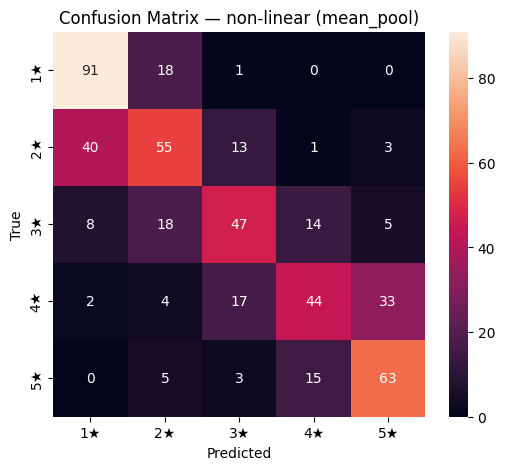

classifier_type-non-linear context_rep-mean_pool
Accuracy: 0.6000


In [20]:
# Hyperparameters
CLF_TYPE = 'non-linear'
LEARNING_RATE = 0.0005
BATCH_SIZE = 32

# 3) Build embedding loaders (much faster)
train_emb_loader = DataLoader(EmbeddingDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_emb_loader   = DataLoader(EmbeddingDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_emb_loader  = DataLoader(EmbeddingDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# 4) Train a small head for many epochs cheaply
hidden_size = X_train.shape[1]
head = make_head(hidden_size, num_labels=5, classifier_type=CLF_TYPE).to(device)
opt = torch.optim.AdamW(head.parameters(), lr=LEARNING_RATE)

best_head = train_head(head, train_emb_loader, val_emb_loader, opt, device, num_epochs=10, eval_every_epochs=1)
ret = evaluate_and_plot(best_head, test_emb_loader, device, classifier_type=CLF_TYPE, context_rep=CONTEXT_REP)

## **Part 4: Bakeoff (20 points)**

In this final section, you will take part in a friendly competition. You may use **any classifier of your choice** to generate predictions for a set of unlabeled examples.

Download the data from the Kaggle link:  https://www.kaggle.com/t/6f431e5fab1648e4a8af869a44405984

You are given two CSV files:

- `text.csv` — Contains two columns: an ID and the corresponding raw text. You must generate a prediction for each row.
- `sample_submission.csv` — Shows the required format for your submission file.

Once you have generated your predictions, submit them to the Kaggle competition using the above link.

In [22]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class YelpPredictDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(0)
        }

df_new = pd.read_csv('text.csv')
predict_ds = YelpPredictDataset(df_new['text'].tolist(), tokenizer)
predict_loader = DataLoader(predict_ds, batch_size=32, shuffle=False)

X_new, _ = compute_embeddings(bert, predict_loader, device, context_rep="mean_pool")

best_head.eval()
with torch.no_grad():
    X_new = X_new.to(device)
    logits = best_head(X_new)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

submission = pd.DataFrame({
    'Id': df_new['Id'],
    'label': preds
})

submission.to_csv('submission.csv', index=False)
print(submission.head())

Embedding (mean_pool):   0%|          | 0/32 [00:00<?, ?it/s]

   Id  label
0   0      4
1   1      1
2   2      1
3   3      1
4   4      3
